# Additional figures

In [2]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

## Event frequency duration curve

In [21]:
data_path = 'Prelim_Data/events_subdf.csv'
df_events = pd.read_csv(data_path, index_col=0)
df_events

,site_no,event,start,end,hmf,duration
0,13335050,1,1991-05-19,1991-06-01,0.004083,14
1,13335050,2,1991-06-30,1991-07-02,0.000413,3
2,13335050,3,1993-03-24,1993-03-28,0.001032,5
3,13335050,4,1993-04-03,1993-04-07,0.000773,5
4,13335050,5,1993-04-09,1993-04-09,0.000010,1
...,...,...,...,...,...,...
160,11447650,50,2018-04-06,2018-04-13,0.317321,8
161,11447650,51,2019-01-19,2019-01-24,0.073153,6
162,11447650,52,2019-02-06,2019-02-09,0.035965,4
163,11447650,53,2019-02-13,2019-02-24,0.499591,12


In [25]:
dict_events = {}
for col in df_events.site_no.unique().tolist():
    dict_events[str(col)] = df_events[df_events['site_no'] == col]

13335050
11447650


In [49]:
sites = df_events.site_no.unique().tolist()
sites = [str(value) for value in sites]
sites

['13335050', '11447650']

In [59]:
def sort_events(df):
    df_sort_dur = df.sort_values('duration')
    #df_sort_mean = df_sort_dur.groupby('duration').mean()
    df_sort = df_sort_dur.groupby('duration')['hmf'].agg(['mean', 'size']).reset_index()
    df_sort = df_sort.rename(columns={'size':'count'})
    df_sort = df_sort.rename(columns={'mean':'hmf'})  
    return df_sort

df_events = {}
for site in sites:
    df = dict_events[site]
    df_events[site] = sort_events(df)

df_events

{'13335050':     duration       hmf  count
 0          1  0.000026     21
 1          2  0.000152     12
 2          3  0.000481     13
 3          4  0.001430      3
 4          5  0.000838     16
 5          6  0.001090      3
 6          7  0.005111      1
 7          8  0.001847      2
 8          9  0.002443      4
 9         10  0.005019      2
 10        11  0.002302      1
 11        12  0.007865      2
 12        13  0.007861      6
 13        14  0.003563      2
 14        15  0.002312      3
 15        16  0.006580      4
 16        17  0.008754      1
 17        19  0.017647      1
 18        20  0.005805      2
 19        21  0.005671      1
 20        26  0.013004      1
 21        29  0.004773      1
 22        33  0.024825      1
 23        36  0.017415      1
 24        37  0.025633      1
 25        41  0.015457      1
 26        44  0.020282      1
 27        45  0.026927      1
 28        47  0.035304      1
 29        51  0.011333      1
 30        65  0.029095    

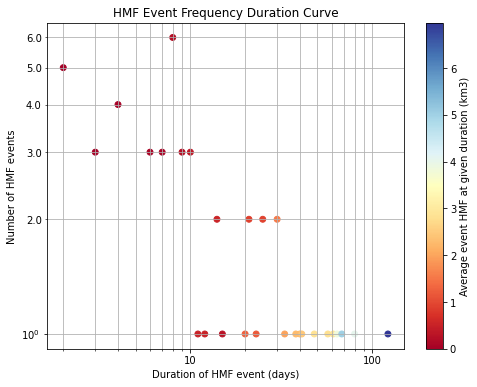

In [96]:
import matplotlib.ticker as mticker

df_plot = df_events['11447650']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

cm = plt.cm.get_cmap('RdYlBu')
scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=35, cmap=cm)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Average event HMF at given duration (km3)')

ax.set_xlabel('Duration of HMF event (days)')
ax.set_ylabel('Number of HMF events')
ax.set_title('HMF Event Frequency Duration Curve')

plt.xscale("log")
plt.yscale("log")

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_minor_formatter().set_scientific(False)
ax.yaxis.get_minor_formatter().set_useOffset(False)

plt.grid('True', which="both", ls="-")

plt.show()

In [35]:
(0.031316+0.073153+0.133094)/3

0.07918766666666666